<a href="https://colab.research.google.com/github/Praveen76/Conversation-AI-System-using-LLMs-on-E-commerce-Data/blob/main/Finetune_BERT_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q transformers
!pip install imbalanced-learn



In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load DataFrame
df = pd.read_csv("./OSS_LLMs_Data.csv")
df = df[['review_content', 'Sentiment']]

# Define a mapping function
sentiment_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}
df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)

# Assuming df is your DataFrame
max_length = 1400
df = df[df['review_content'].apply(lambda x: len(x) <= max_length)]

print(f'Original dataset shape: {Counter(df["Sentiment"])}')





Original dataset shape: Counter({2: 454, 0: 71, 1: 40})


In [8]:

# Split into train, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['review_content'], df['Sentiment'],
                                                                    random_state=2021,
                                                                    test_size=0.3,
                                                                    stratify=df['Sentiment'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [9]:


# Import BERT-base pretrained model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(array([76., 90., 73., 76., 79., 24., 54., 43., 21., 29.]),
 array([ 11. ,  34.5,  58. ,  81.5, 105. , 128.5, 152. , 175.5, 199. ,
        222.5, 246. ]),
 <BarContainer object of 10 artists>)

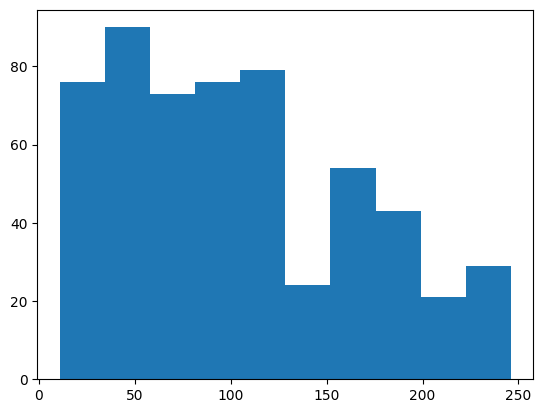

In [10]:
lens=[len(i.split()) for i in df.review_content]

import matplotlib.pyplot as plt
plt.hist(lens)


In [11]:


# Tokenize and encode sequences
pad_len = 512
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length=pad_len, pad_to_max_length=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length=pad_len, pad_to_max_length=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length=pad_len, pad_to_max_length=True, truncation=True)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

train_y = torch.tensor(train_labels.tolist())
val_y = torch.tensor(val_labels.tolist())
test_y = torch.tensor(test_labels.tolist())

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
# Define batch size
batch_size = 64

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
# Freeze the BERT architecture
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
# Define the sentiment classification model
class SentimentClassifier(nn.Module):
    def __init__(self, bert_model, num_classes=3):
        super(SentimentClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize the model
model = SentimentClassifier(bert, num_classes=3)
model = model.to(device)

In [ ]:

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function
cross_entropy = nn.NLLLoss(weight=weights)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

# Number of training epochs
epochs = 1

# Training loop
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()


In [ ]:

# Evaluate the model
model.eval()
all_preds = []
with torch.no_grad():
    for step, batch in enumerate(val_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        preds = model(sent_id, mask)
        all_preds.append(preds.detach().cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
pred_labels = np.argmax(all_preds, axis=1)

print(classification_report(val_y.numpy(), pred_labels, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        10
           1       1.00      0.00      0.00         6
           2       0.81      1.00      0.90        69

    accuracy                           0.81        85
   macro avg       0.94      0.33      0.30        85
weighted avg       0.85      0.81      0.73        85



In [50]:
df.Sentiment.nunique()

3

In [13]:
########################################## Method 2 ##########################################

# Loading and fine-tuning BERT
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels = df.Sentiment.nunique(),
)
model.to(device)
model.train()

optim = torch.optim.Adam(model.parameters(), lr = 5e-5)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def compute_accuracy(model, data_loader, device):
  with torch.no_grad():
    correct_pred, num_examples = 0,0
    for batch_idx, batch in enumerate(data_loader):
      ## prepare data
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      labels = batch[2].to(device)
      outputs = model(input_ids, attention_mask = attention_mask)
      logits = outputs['logits']
      predicted_labels = torch.argmax(logits, 1)
      num_examples += labels.size(0)
      correct_pred += (predicted_labels == labels).sum()
  return correct_pred.float()/num_examples * 100

In [15]:
# Define batch size
batch_size = 64

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [16]:
# Training (fine-tuning) loop
import time
start_time = time.time()

N_EPOCHS = 1
for epoch in range(N_EPOCHS):
  model.train()

  for batch_idx, batch in enumerate(train_dataloader):

    ## prepare data
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    ## forward pass
    outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
    loss, logits = outputs['loss'], outputs['logits']

    ## backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()

    ## logging
    if not batch_idx % 250:
      print(f'Epoch : {epoch+1}/{N_EPOCHS:04d}'
            f' | Batch'
            f'{batch_idx:04d}/'
            f'{len(train_dataloader):04d} |'
            f'Loss: {loss:.4f}')

    model.eval()

    with torch.set_grad_enabled(False):
      print(f'Training accuracy: '
            f'{compute_accuracy(model, train_dataloader, device):.2f}%'
            f'\nValid accuracy: '
            f'{compute_accuracy(model, val_dataloader, device):.2f}%')

  print(f'Time elapsed: {(time.time() -start_time) / 60:.2f} min')
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test Accuracy: {compute_accuracy(model, test_dataloader, device):.2f}%')

Epoch : 1/0001 | Batch0000/0007 |Loss: 1.2661
Training accuracy: 18.48%
Valid accuracy: 12.94%
Training accuracy: 80.25%
Valid accuracy: 81.18%
Training accuracy: 80.25%
Valid accuracy: 81.18%
Training accuracy: 80.25%
Valid accuracy: 81.18%
Training accuracy: 80.25%
Valid accuracy: 81.18%
Training accuracy: 80.25%
Valid accuracy: 81.18%
Training accuracy: 80.25%
Valid accuracy: 81.18%
Time elapsed: 29.70 min
Total Training Time: 29.70 min
Test Accuracy: 80.00%


In [ ]:
###################################################### Method 4 ######################################################

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_data = tokenizer(df["review_content"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_data = dict(tokenized_data)

labels = np.array(df["Sentiment"])  # Label is already an array of 0 and 1

In [ ]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

# Load and compile our model
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels = df.Sentiment.nunique())
# Lower learning rates are often better for fine-tuning transformers
model.compile(optimizer=Adam(3e-5))  # No loss argument!

model.fit(tokenized_data, labels)

In [ ]:
# tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

In [ ]:
tf_dataset = model.prepare_tf_dataset(dataset["train"], batch_size=16, shuffle=True, tokenizer=tokenizer)

In [ ]:
model.compile(optimizer=Adam(3e-5))  # No loss argument!

model.fit(tf_dataset)

In [ ]:
####################################### Distributed training with Accelerate #######################################


In [17]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 5.6 MB/s eta 0:00:00


In [ ]:
from tqdm.auto import tqdm
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=df.Sentiment.nunique())
optimizer = AdamW(model.parameters(), lr=3e-5)

model.to(device)

train_dataloader, val_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, val_dataloader, model, optimizer
)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

# Initialize checkpoint outside the loop
checkpoint_path = "./checkpoints/checkpoint_epoch_{epoch}.pth"

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        inputs = {
            'input_ids': batch[0].to(device),
            'attention_mask': batch[1].to(device),
            'labels': batch[2].to(device)
        }

        outputs = model(**inputs)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Save checkpoint at the end of each epoch
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'other_info': 'additional_information_if_needed',
        'epoch': epoch + 1
    }

    torch.save(checkpoint, checkpoint_path.format(epoch=epoch + 1))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/21 [00:00<?, ?it/s]